In [2]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt

Tensorflow version: 2.16.1


In [3]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='uniform',
                                              trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='uniform',
                                           trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:, :, :4], axis=-1)
        time_linear = self.weights_linear * x + self.bias_linear  # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1)  # Add dimension (batch, seq_len, 1)

        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1)  # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1)  # shape = (batch, seq_len, 2)

    def get_config(self):  # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config

In [4]:
class SingleAttention(Layer):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

    def build(self, input_shape):
        self.query = Dense(self.d_k,
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

        self.key = Dense(self.d_k,
                         input_shape=input_shape,
                         kernel_initializer='glorot_uniform',
                         bias_initializer='glorot_uniform')

        self.value = Dense(self.d_v,
                           input_shape=input_shape,
                           kernel_initializer='glorot_uniform',
                           bias_initializer='glorot_uniform')

    def call(self, inputs):  # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x / np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)

        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out

In [6]:
class MultiAttention(Layer):
    def __init__(self, d_k, d_v, n_heads):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.attn_heads = list()

    def build(self, input_shape):
        for n in range(self.n_heads):
            self.attn_heads.append(SingleAttention(self.d_k, self.d_v))

            # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7
        self.linear = Dense(input_shape[0][-1],
                            input_shape=input_shape,
                            kernel_initializer='glorot_uniform',
                            bias_initializer='glorot_uniform')

    def call(self, inputs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        concat_attn = tf.concat(attn, axis=-1)
        multi_linear = self.linear(concat_attn)
        return multi_linear

In [7]:
class TransformerEncoder(Layer):
    def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.attn_heads = list()
        self.dropout_rate = dropout

    def build(self, input_shape):
        self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
        self.attn_dropout = Dropout(self.dropout_rate)
        self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

        self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
        # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7
        self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1)
        self.ff_dropout = Dropout(self.dropout_rate)
        self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    def call(self, inputs):  # inputs = (in_seq, in_seq, in_seq)
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = self.ff_conv1D_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer

    def get_config(self):  # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'d_k': self.d_k,
                       'd_v': self.d_v,
                       'n_heads': self.n_heads,
                       'ff_dim': self.ff_dim,
                       'attn_heads': self.attn_heads,
                       'dropout_rate': self.dropout_rate})
        return config
    

In [9]:
from sklearn.preprocessing import MinMaxScaler

# 讀取資料集
tsmc_data = pd.read_csv('./tsmc_stock_prices_INT.csv')
tsmc_data.index = tsmc_data["date"]
tsmc_data = tsmc_data.drop(columns=["date"])
print(tsmc_data.head())

# 定義參數
input_length = 30  # 輸入序列長度
output_length = 1  # 輸出序列長度
test_percentage = 0.2  # 測試集比例

# 將 'high', 'low', 'open', 'close' 四個欄位的資料轉換為numpy array
dataset = tsmc_data[['high', 'low', 'open', 'close']].to_numpy()

# 正規化資料
scaler = MinMaxScaler()
dataset_norm = scaler.fit_transform(dataset)

# 創建訓練集和測試集
dataset_list = []
for i in range(len(dataset) - input_length - output_length):
    dataset_list.append(dataset_norm[i:i + input_length + output_length])
dataset_list = np.array(dataset_list)

# 分割訓練集和測試集
trainset = dataset_list[:int(len(dataset_list) * (1 - test_percentage))]
testset = dataset_list[int(len(dataset_list) * (1 - test_percentage)):]

# 分割特徵和標籤
x_train = trainset[:, :-output_length]
y_train = trainset[:, -output_length:, :]  # 取最後output_length個值作為標籤
x_test = testset[:, :-output_length]
y_test = testset[:, -output_length:, :]  # 取最後output_length個值作為標籤

# 輸出訓練集和測試集的shape
print('x_train.shape:' + str(x_train.shape))
print('y_train.shape:' + str(y_train.shape))
print('x_test.shape:' + str(x_test.shape))
print('y_test.shape:' + str(y_test.shape))


          high  low  open  close
date                            
20100104    65   64    65     64
20100105    65   63    65     64
20100106    64   63    64     64
20100107    65   64    64     64
20100108    64   63    63     64
x_train.shape:(2718, 30, 4)
y_train.shape:(2718, 1, 4)
x_test.shape:(680, 30, 4)
y_test.shape:(680, 1, 4)


In [10]:
batch_size = 128
seq_len = 30

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

In [31]:
# time_embedding_c = Time2Vector(seq_len)
# attn_layer1_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
# attn_layer2_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
# attn_layer3_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

# in_seq_c = Input(shape=(seq_len, 4))
# x_c = time_embedding_c(in_seq_c)
# x_c = Concatenate(axis=-1)([in_seq_c, x_c])
# x_c = attn_layer1_c((x_c, x_c, x_c))
# x_c = attn_layer2_c((x_c, x_c, x_c))
# x_c = attn_layer3_c((x_c, x_c, x_c))
# x_c = GlobalAveragePooling1D(data_format='channels_first')(x_c)
# x_c = Dropout(0.1)(x_c)
# x_c = Dense(64, activation='relu')(x_c)
# x_c = Dropout(0.1)(x_c)
# out_c = Dense(4, activation='linear')(x_c)

# model = Model(inputs=[in_seq_c], outputs=[out_c])

# model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])

time_embedding_c = Time2Vector(seq_len)
attn_layer1_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
attn_layer2_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
attn_layer3_c = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

in_seq_c = Input(shape=(seq_len, 4))
x_c = time_embedding_c(in_seq_c)
x_c = Concatenate(axis=-1)([in_seq_c, x_c])
x_c = attn_layer1_c((x_c, x_c, x_c))
x_c = attn_layer2_c((x_c, x_c, x_c))
x_c = attn_layer3_c((x_c, x_c, x_c))
x_c = GlobalAveragePooling1D(data_format='channels_first')(x_c)
x_c = Dropout(0.1)(x_c)
x_c = Dense(64, activation='relu')(x_c)
x_c = Dropout(0.1)(x_c)
# 分別預測 'high', 'low', 'open', 'close' 四個值
out_high = Dense(1, activation='linear', name='out_high')(x_c)
out_low = Dense(1, activation='linear', name='out_low')(x_c)
out_open = Dense(1, activation='linear', name='out_open')(x_c)
out_close = Dense(1, activation='linear', name='out_close')(x_c)

model = Model(inputs=[in_seq_c], outputs=[out_high, out_low, out_open, out_close])

# model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
model.compile(loss={'out_high': 'mse', 'out_low': 'mse', 'out_open': 'mse', 'out_close': 'mse'},
              optimizer='adam',
              metrics={'out_high': ['mae', 'mape'], 'out_low': ['mae', 'mape'], 'out_open': ['mae', 'mape'], 'out_close': ['mae', 'mape']})



In [32]:
print(model.summary())

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 30, 4)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ time2_vector_6 (Time2Vector)  │ (None, 30, 2)             │             120 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_6 (Concatenate)   │ (None, 30, 6)             │               0 │ input_layer_6[0][0],       │
│                               │                           │                 │ time2_vector_6[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_encoder_18        │ (None, 30, 6)             │          86,308 │ concatenate_6[0][0],       │
│ (TransformerEncoder)          │                           │                 │ concatenate_6[0][0],       │
│                               │                           │                 │ concatenate_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_encoder_19        │ (None, 30, 6)             │          86,308 │ transformer_encoder_18[0]… │
│ (TransformerEncoder)          │                           │                 │ transformer_encoder_18[0]… │
│                               │                           │                 │ transformer_encoder_18[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_encoder_20        │ (None, 30, 6)             │          86,308 │ transformer_encoder_19[0]… │
│ (TransformerEncoder)          │                           │                 │ transformer_encoder_19[0]… │
│                               │                           │                 │ transformer_encoder_19[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d_5    │ (None, 30)                │               0 │ transformer_encoder_20[0]… │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_54 (Dropout)          │ (None, 30)                │               0 │ global_average_pooling1d_… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_786 (Dense)             │ (None, 64)                │           1,984 │ dropout_54[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_55 (Dropout)          │ (None, 64)                │               0 │ dense_786[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ out_high (Dense)              │ (None, 1)                 │              65 │ dropout_55[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ out_low (Dense)               │ (None, 1)                 │              65 │ dropout_55[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ out_open (Dense)              │ (None, 1)                 │              65 │ dropout_55[0][0]           │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 261,288 (1020.66 KB)

 Trainable params: 261,288 (1020.66 KB)

 Non-trainable params: 0 (0.00 B)

None


In [33]:
# history = model.fit([x_train],[y_train],
#                     batch_size=batch_size,
#                     epochs=10)

history = model.fit(x_train,
                    {'out_high': y_train[:, :, 0], 'out_low': y_train[:, :, 1], 'out_open': y_train[:, :, 2], 'out_close': y_train[:, :, 3]},
                    batch_size=batch_size,
                    epochs=10)



Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 418ms/step - loss: 0.2286 - out_close_mae: 0.1683 - out_close_mape: 110.1337 - out_high_mae: 0.1694 - out_high_mape: 104.5913 - out_low_mae: 0.1584 - out_low_mape: 37193.3750 - out_open_mae: 0.1670 - out_open_mape: 111.8268
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 408ms/step - loss: 0.1091 - out_close_mae: 0.1154 - out_close_mape: 333.9612 - out_high_mae: 0.1166 - out_high_mape: 302.9982 - out_low_mae: 0.1213 - out_low_mape: 70161.6484 - out_open_mae: 0.1158 - out_open_mape: 334.6021
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 416ms/step - loss: 0.0260 - out_close_mae: 0.0435 - out_close_mape: 141.5409 - out_high_mae: 0.0456 - out_high_mape: 142.1460 - out_low_mae: 0.0420 - out_low_mape: 57250.5547 - out_open_mae: 0.0426 - out_open_mape: 145.2529
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 406ms/step - loss: 0.0073 - out_close_mae: 0.0267 - out_close_mape: 45.3393 - out_high_mae: 0.0274 - out_high_mape: 40.9174 - out_low_mae: 0.0278 - out_low_mape: 2

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


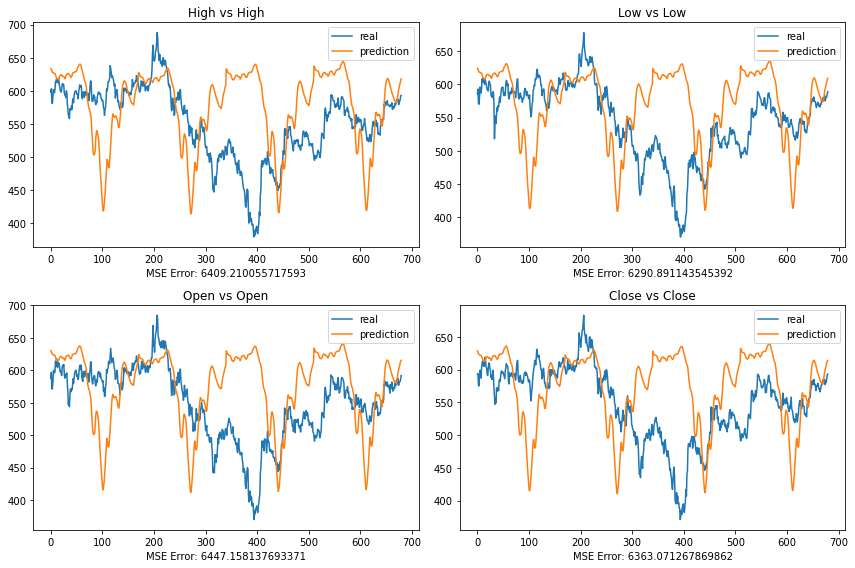

In [37]:
from sklearn.metrics import mean_squared_error
y_predict = model.predict(x_test)
y_real = scaler.inverse_transform(y_test.reshape(-1, 4))
y_predict = scaler.inverse_transform(np.array(y_predict).reshape(-1, 4))
# plt.figure(1)
# plt.plot(y_real, label='real')
# plt.plot(y_predict, label='prediction')
# plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real, y_predict)))
# plt.legend()
# plt.title('Prediction result')
# plt.show()

plt.figure(figsize=(12, 8))

# 高 vs 高
plt.subplot(2, 2, 1)
plt.plot(y_real[:, 0], label='real')
plt.plot(y_predict[:, 0], label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real[:, 0], y_predict[:, 0])))
plt.legend()
plt.title('High vs High')

# 低 vs 低
plt.subplot(2, 2, 2)
plt.plot(y_real[:, 1], label='real')
plt.plot(y_predict[:, 1], label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real[:, 1], y_predict[:, 1])))
plt.legend()
plt.title('Low vs Low')

# 開 vs 開
plt.subplot(2, 2, 3)
plt.plot(y_real[:, 2], label='real')
plt.plot(y_predict[:, 2], label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real[:, 2], y_predict[:, 2])))
plt.legend()
plt.title('Open vs Open')

# 收 vs 收
plt.subplot(2, 2, 4)
plt.plot(y_real[:, 3], label='real')
plt.plot(y_predict[:, 3], label='prediction')
plt.xlabel('MSE Error: {}'.format(mean_squared_error(y_real[:, 3], y_predict[:, 3])))
plt.legend()
plt.title('Close vs Close')

plt.tight_layout()
plt.show()
